In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7
N = 15

## solve the period finding problem for a=7 and N=15

In [25]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod %i" % (a, power, N)
    c_U = U.control()
    
    return c_U

## import the circuit for the QFT

In [26]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    
    # Don't forget the Swaps!
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp( -np.pi / float(2 ** (j - m) ), m, j)
        qc.h(j)
    qc.name = "QFT†"
    
    return qc

## building blocks we can easily construct the circuit for Shor's algorithm

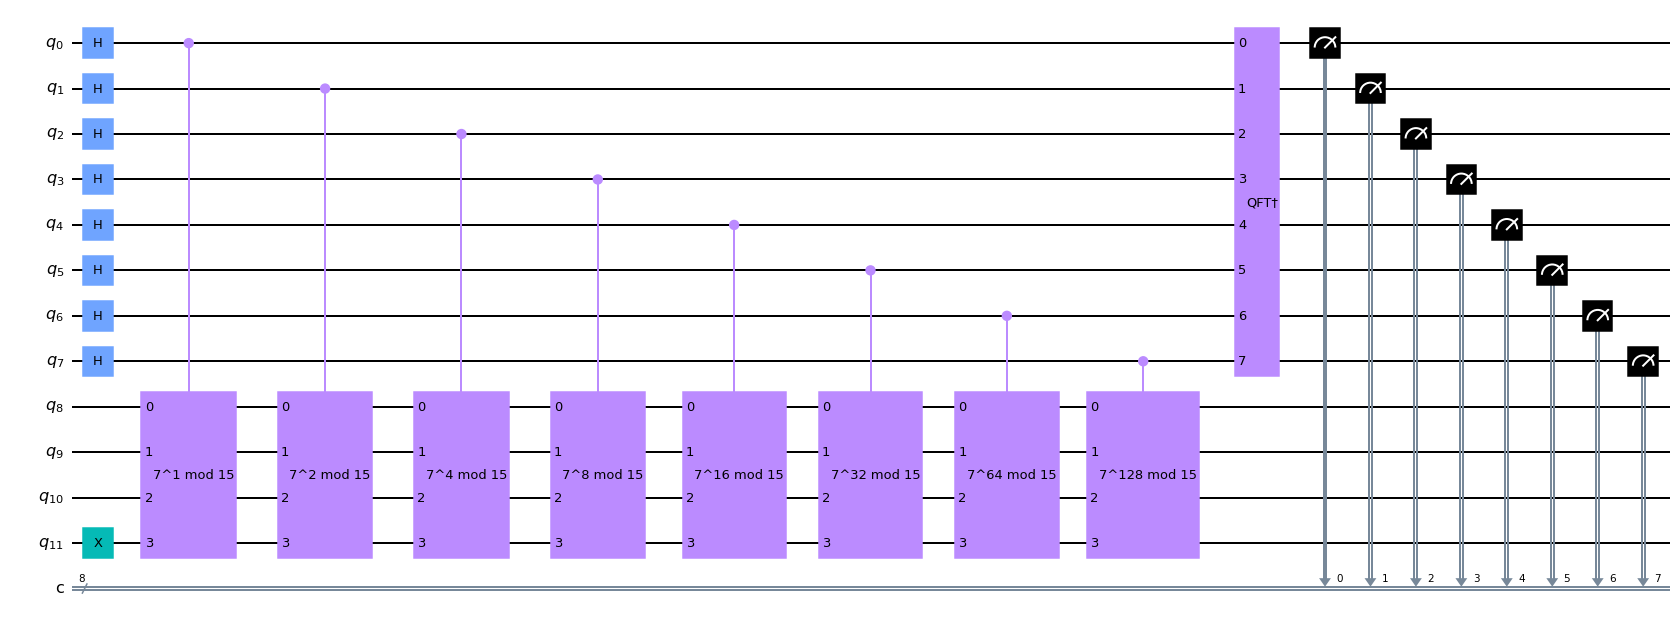

In [27]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3 + n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(
        c_amod15(a, 2 ** q), 
        [q] + [i + n_count for i in range(4)]
    )

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold = -1, output='mpl')  # -1 means 'do not fold' 

## results we measure

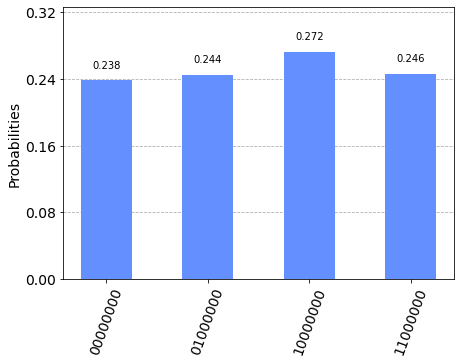

In [20]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj, shots=2000).result()
counts = results.get_counts()
plot_histogram(counts)

## Since we have 8 qubits, these results correspond to measured phases of

In [23]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal / (2 ** n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])

# Print the rows in a table
headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)

print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [32]:
from math import gcd

def guessNum(r):
    res = []
    res.append(gcd(a ** (r // 2) + 1, N))
    res.append(gcd(a ** (r // 2) - 1, N))
    
    return sorted(res)

In [34]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator, guessNum(frac.denominator)])

# Print as a table
headers=["Phase", "Fraction", "Guess for r", 'Guess Number']
df = pd.DataFrame(rows, columns=headers)

print(df)

   Phase Fraction  Guess for r Guess Number
0   0.75      3/4            4       [3, 5]
1   0.50      1/2            2       [1, 3]
2   0.25      1/4            4       [3, 5]
3   0.00      0/1            1      [1, 15]
